# Apple leaf disease detection

## Libraries

In [48]:
!pip install pytorch-gradcam opencv-python

In [51]:
import pandas as pd
import numpy as np
import zipfile
import os
import random
from PIL import Image, ImageStat, ImageEnhance
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.transforms as transforms
import torch
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.metrics import confusion_matrix

## Load the dataset

Dataset: https://www.kaggle.com/datasets/nirmalsankalana/apple-tree-leaf-disease-dataset/data

In [2]:
zip_file_path = '/content/archive.zip'
extract_dir = 'extracted_content'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir) # Extract all the contents

print(f"Successfully extracted '{zip_file_path}' to '{extract_dir}'")

Successfully extracted '/content/archive.zip' to 'extracted_content'


In [3]:
# Categories
categories = [d for d in os.listdir(extract_dir) if os.path.isdir(os.path.join(extract_dir, d))]

print("Categories found:", categories)

Categories found: ['Alternaria leaf spot', 'Brown spot', 'Rust', 'Healthy leaf', 'Gray spot']


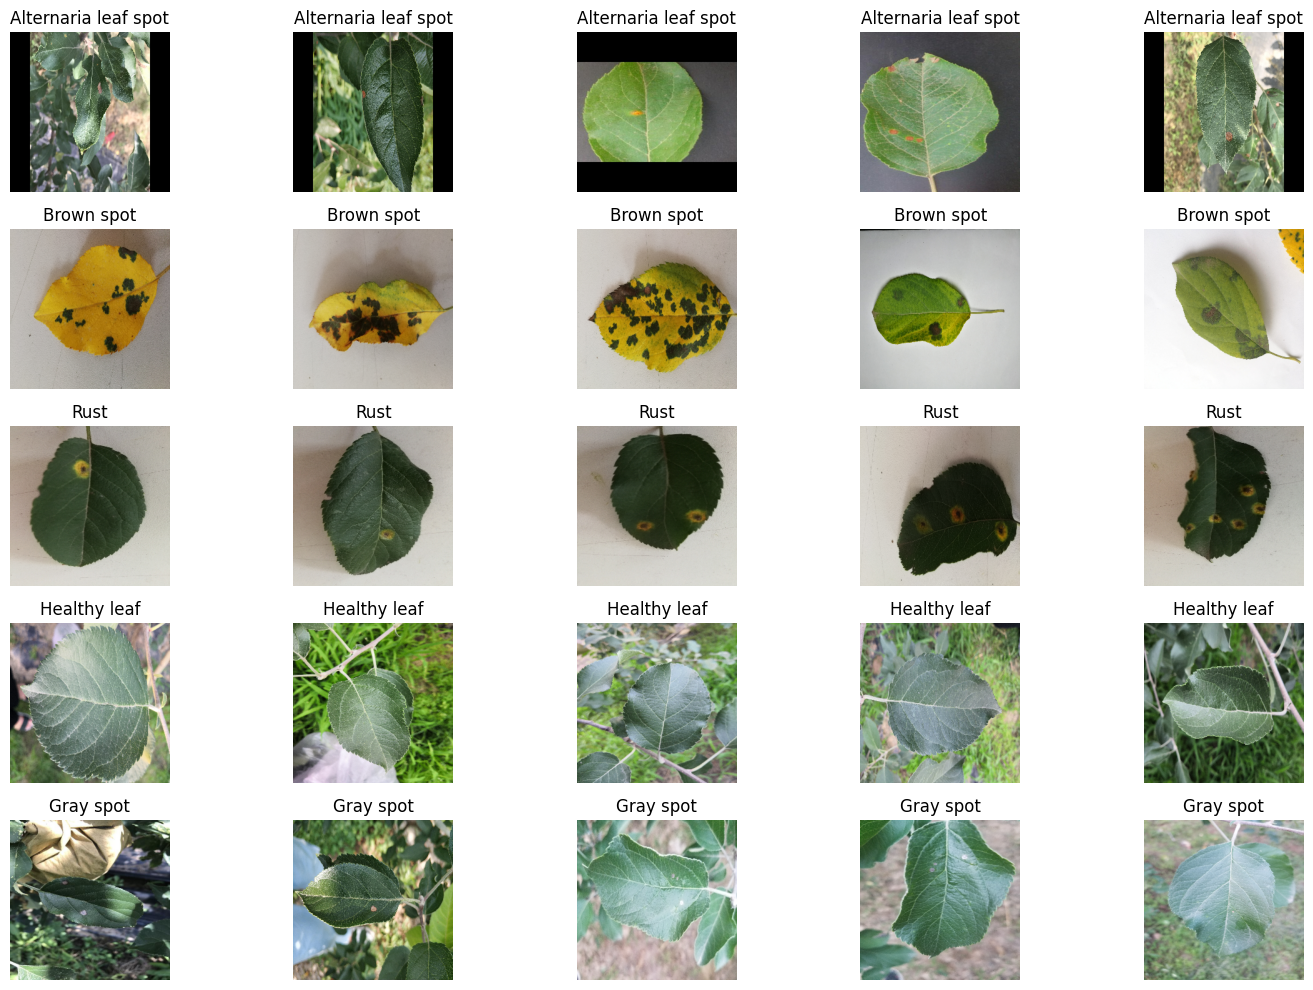

In [4]:
plt.figure(figsize=(15, 10))

# Visualize 5 images from each category
for i, category in enumerate(categories):
    category_path = os.path.join(extract_dir, category)
    image_files = [os.path.join(category_path, f) for f in os.listdir(category_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    # Select up to 5 random images from the category
    selected_images = random.sample(image_files, min(5, len(image_files)))

    # Display the images
    for j, img_path in enumerate(selected_images):
        img = Image.open(img_path)
        # Calculate subplot position: (category_index * 5) + image_index + 1
        plt.subplot(len(categories), 5, (i * 5) + j + 1)
        plt.imshow(img)
        plt.title(category)
        plt.axis('off')

plt.tight_layout()
plt.show()

## Exploratory Data Analysis (EDA)

### Dataset overview: Count images per category

In [5]:
data_overview = {}
for category in categories:
    category_path = os.path.join(extract_dir, category)
    image_files = [f for f in os.listdir(category_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    data_overview[category] = len(image_files)

# Display the counts
for category, count in data_overview.items():
    print(f"Category '{category}': {count} images")

Category 'Alternaria leaf spot': 278 images
Category 'Brown spot': 143 images
Category 'Rust': 107 images
Category 'Healthy leaf': 409 images
Category 'Gray spot': 266 images


### Image inspection: Check resolution, color profiles, and visualize samples from each class.

In [ ]:
# Number of sample images to inspect per category
num_samples = 3

print(f"Inspecting {num_samples} sample images from each category:")

# plt.figure(figsize=(15, len(categories) * 3)) # Removed figure creation

# Inspect sample images from each category
for i, category in enumerate(categories):
    category_path = os.path.join(extract_dir, category)
    image_files = [os.path.join(category_path, f) for f in os.listdir(category_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    # Select random sample images from the category
    selected_images = random.sample(image_files, min(num_samples, len(image_files)))

    print(f"\nCategory: {category}")
    for j, img_path in enumerate(selected_images):
        try:
            img = Image.open(img_path)
            print(f"  Image: {os.path.basename(img_path)}")
            print(f"    Resolution: {img.size}")
            print(f"    Color Profile: {img.mode}")

            # Removed display code:
            # plt.subplot(len(categories), num_samples, (i * num_samples) + j + 1)
            # plt.imshow(img)
            # plt.title(f"{category}\n{os.path.basename(img_path)}")
            # plt.axis('off')
            img.close() # Close the image file after processing

        except Exception as e:
            print(f"  Could not process image {os.path.basename(img_path)}: {e}")


# Removed plot display
# plt.tight_layout()
# plt.show()

Inspecting 3 sample images from each category:

Category: Healthy leaf
  Image: IMG_20190726_195432.jpg
    Resolution: (256, 256)
    Color Profile: RGB
  Image: IMG_20190726_192702.jpg
    Resolution: (256, 256)
    Color Profile: RGB
  Image: IMG_20190726_194144.jpg
    Resolution: (256, 256)
    Color Profile: RGB

Category: Brown spot
  Image: 001821.jpg
    Resolution: (256, 256)
    Color Profile: RGB
  Image: 001733.jpg
    Resolution: (256, 256)
    Color Profile: RGB
  Image: 001571.jpg
    Resolution: (256, 256)
    Color Profile: RGB

Category: Rust
  Image: 004859.jpg
    Resolution: (256, 256)
    Color Profile: RGB
  Image: IMG_20190727_163112.jpg
    Resolution: (256, 256)
    Color Profile: RGB
  Image: IMG_20190727_164151.jpg
    Resolution: (256, 256)
    Color Profile: RGB

Category: Gray spot
  Image: 20190726_192606.jpg
    Resolution: (256, 256)
    Color Profile: RGB
  Image: 003241.jpg
    Resolution: (256, 256)
    Color Profile: RGB
  Image: IMG_20190727_1505

The output shows that the sample images from all categories have a consistent resolution of (256, 256) and use the RGB color profile. This uniformity in size and color format is beneficial for processing these images for a machine learning model. We might not need to resize or convert images before feeding them into a model, simplifying the preprocessing steps.

### Data balance: Plot class counts to reveal any imbalance.

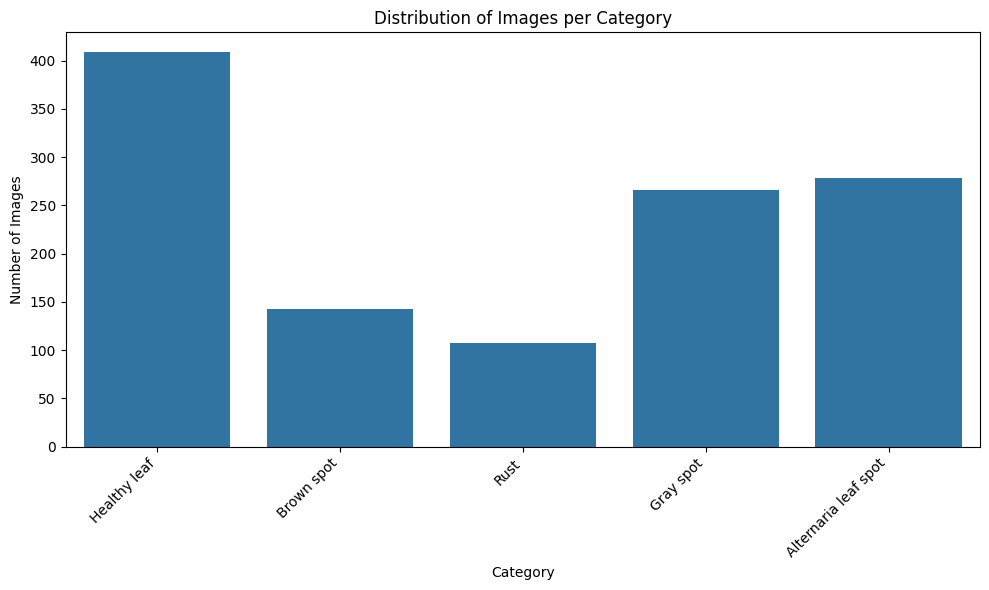

In [ ]:
# Convert the data_overview dictionary to a pandas DataFrame for easier plotting
data_overview_df = pd.DataFrame(list(data_overview.items()), columns=['Category', 'Count'])

# Create a bar plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='Count', data=data_overview_df)
plt.title('Distribution of Images per Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.tight_layout()
plt.show()

The distribution of the classes show that the dataset is imbalanced. The 'Healthy leaf' category has significantly more images (409) compared to 'Rust' (107) and 'Brown spot' (143). Training a model on an imbalanced dataset can lead to the model performing well on the majority class ('Healthy leaf') but poorly on the minority classes ('Rust', 'Brown spot'). We might need to consider techniques like data augmentation, oversampling minority classes, or undersampling majority classes to address this imbalance during the data preparation phase.

### Image variation: Analyze leaf appearance (lighting, background, angle); compute image brightness, contrast, color histograms.

In [ ]:
# Get the list of categories (subdirectories)
categories = [d for d in os.listdir(extract_dir) if os.path.isdir(os.path.join(extract_dir, d))]

# Number of sample images to analyze per category
num_samples_analysis = 5

print(f"Analyzing image variation for {num_samples_analysis} sample images from each category:")

image_analysis_results = {}

for category in categories:
    category_path = os.path.join(extract_dir, category)
    image_files = [os.path.join(category_path, f) for f in os.listdir(category_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    # Select random sample images from the category
    selected_images = random.sample(image_files, min(num_samples_analysis, len(image_files)))

    print(f"\nCategory: {category}")
    category_results = []

    for img_path in selected_images:
        try:
            img = Image.open(img_path).convert("RGB") # Convert to RGB to ensure consistent color profile
            stat = ImageStat.Stat(img)

            # Calculate brightness (mean of RGB values)
            brightness = stat.mean

            # Calculate contrast (standard deviation of pixel values - a simple approximation)
            # A more robust method might involve analyzing the histogram
            contrast = stat.stddev

            # Calculate color histogram
            # For simplicity, we'll get a flattened histogram
            histogram = img.histogram()

            print(f"  Image: {os.path.basename(img_path)}")
            print(f"    Brightness (Mean RGB): {brightness}")
            print(f"    Contrast (Std Dev): {contrast}")
            # print(f"    Color Histogram (flattened): {histogram}") # Uncomment to see the raw histogram data

            category_results.append({
                'image': os.path.basename(img_path),
                'brightness': brightness,
                'contrast': contrast,
                'histogram': histogram
            })
            img.close()

        except Exception as e:
            print(f"  Could not process image {os.path.basename(img_path)}: {e}")

    image_analysis_results[category] = category_results

# You can now further process or visualize the 'image_analysis_results' dictionary
# For example, you could calculate average brightness/contrast per category or plot histograms.

Analyzing image variation for 5 sample images from each category:

Category: Healthy leaf
  Image: IMG_20190726_193409.jpg
    Brightness (Mean RGB): [133.94712829589844, 147.16159057617188, 132.01942443847656]
    Contrast (Std Dev): [43.7324116779514, 39.69884010672953, 45.13795860354444]
  Image: IMG_20190726_192008.jpg
    Brightness (Mean RGB): [128.47830200195312, 153.7374267578125, 128.39907836914062]
    Contrast (Std Dev): [40.08373863155992, 35.14505890448768, 40.218535357578595]
  Image: IMG_20190726_192332.jpg
    Brightness (Mean RGB): [116.3707275390625, 143.63284301757812, 125.87852478027344]
    Contrast (Std Dev): [33.70286621304771, 35.25513209189075, 42.88218445234316]
  Image: IMG_20190726_192742.jpg
    Brightness (Mean RGB): [115.44291687011719, 145.14610290527344, 112.75357055664062]
    Contrast (Std Dev): [42.86786317768335, 47.21542208357284, 51.275802468315206]
  Image: IMG_20190726_195557.jpg
    Brightness (Mean RGB): [99.23725891113281, 114.49264526367188,

In [ ]:
# Process the image_analysis_results to calculate average brightness and contrast per category
average_results = []

for category, results in image_analysis_results.items():
    if results:
        # Calculate average brightness (mean of the mean RGB values)
        avg_brightness = [sum(img_result['brightness'][i] for img_result in results) / len(results) for i in range(3)] # Average for R, G, B channels
        # Calculate average contrast (mean of the std dev RGB values)
        avg_contrast = [sum(img_result['contrast'][i] for img_result in results) / len(results) for i in range(3)] # Average for R, G, B channels

        average_results.append({
            'Category': category,
            'Avg_Brightness_R': avg_brightness[0],
            'Avg_Brightness_G': avg_brightness[1],
            'Avg_Brightness_B': avg_brightness[2],
            'Avg_Contrast_R': avg_contrast[0],
            'Avg_Contrast_G': avg_contrast[1],
            'Avg_Contrast_B': avg_contrast[2]
        })

# Convert the average results to a pandas DataFrame
average_results_df = pd.DataFrame(average_results)

# Create DataFrame
average_brightness_melted = average_results_df.melt(id_vars='Category', value_vars=['Avg_Brightness_R', 'Avg_Brightness_G', 'Avg_Brightness_B'], var_name='Metric', value_name='Average Value')
average_contrast_melted = average_results_df.melt(id_vars='Category', value_vars=['Avg_Contrast_R', 'Avg_Contrast_G', 'Avg_Contrast_B'], var_name='Metric', value_name='Average Value')

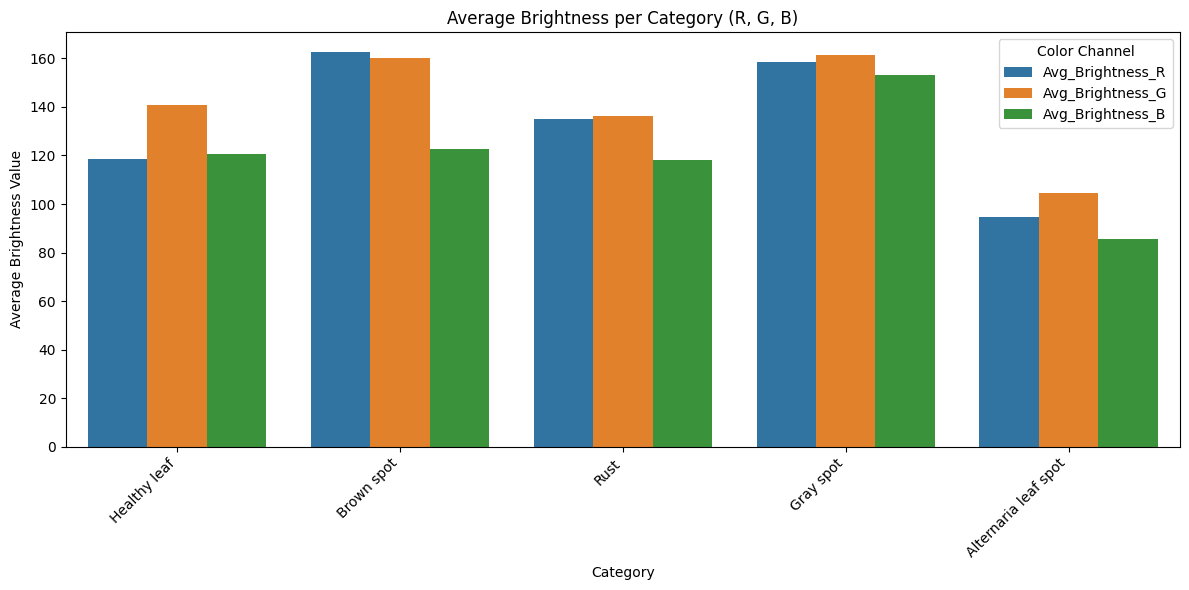

In [ ]:
# Plotting Average Brightness per Category
plt.figure(figsize=(12, 6))
sns.barplot(x='Category', y='Average Value', hue='Metric', data=average_brightness_melted)
plt.title('Average Brightness per Category (R, G, B)')
plt.xlabel('Category')
plt.ylabel('Average Brightness Value')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Color Channel')
plt.tight_layout()
plt.show()

The brightness distribution suggests that 'Gray spot' and 'Brown spot' images tend to be brighter overall, while 'Alternaria leaf spot' images tend to be darker. The 'Healthy leaf' images are characterized by a higher average brightness in the green channel. These differences in average brightness could be distinguishing features for a classification model.

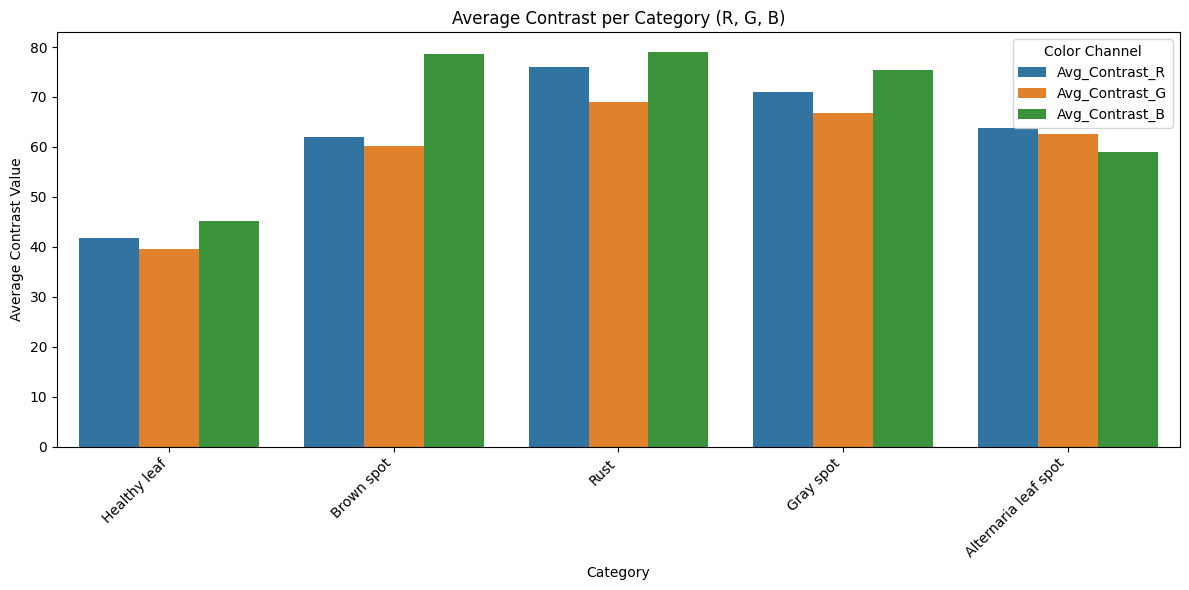

In [ ]:
# Plotting Average Contrast per Category
plt.figure(figsize=(12, 6))
sns.barplot(x='Category', y='Average Value', hue='Metric', data=average_contrast_melted)
plt.title('Average Contrast per Category (R, G, B)')
plt.xlabel('Category')
plt.ylabel('Average Contrast Value')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Color Channel')
plt.tight_layout()
plt.show()

The distribution suggests that images of 'Rust' and 'Gray spot' tend to have higher contrast, potentially indicating more defined features or sharper transitions in color/intensity. 'Healthy leaf' images appear to have lower contrast, which might suggest smoother color gradients or less variation.

## Data Preparation for Modeling

### Data preprocessing pipeline

In [6]:
# Initialize variables to accumulate sums and counts
sum_r = 0
sum_g = 0
sum_b = 0
count = 0

sum_sq_r = 0
sum_sq_g = 0
sum_sq_b = 0

print("Calculating mean and standard deviation of the dataset...")

# Iterate through each category and each image
for category in categories:
    category_path = os.path.join(extract_dir, category)
    image_files = [os.path.join(category_path, f) for f in os.listdir(category_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    for img_path in tqdm(image_files, desc=f"Processing {category}"):
        try:
            img = Image.open(img_path).convert("RGB") # Ensure image is in RGB format
            img_np = np.array(img) / 255.0 # Convert to numpy array and normalize to [0, 1]

            # Accumulate sums
            sum_r += np.sum(img_np[:, :, 0])
            sum_g += np.sum(img_np[:, :, 1])
            sum_b += np.sum(img_np[:, :, 2])

            # Accumulate sums of squares
            sum_sq_r += np.sum(img_np[:, :, 0]**2)
            sum_sq_g += np.sum(img_np[:, :, 1]**2)
            sum_sq_b += np.sum(img_np[:, :, 2]**2)

            # Count the number of pixels
            count += img_np.shape[0] * img_np.shape[1]

            img.close()

        except Exception as e:
            print(f"  Could not process image {os.path.basename(img_path)}: {e}")

# Calculate the mean for each channel
mean_r = sum_r / count
mean_g = sum_g / count
mean_b = sum_b / count

# Calculate the variance for each channel
variance_r = (sum_sq_r / count) - (mean_r**2)
variance_g = (sum_sq_g / count) - (mean_g**2)
variance_b = (sum_sq_b / count) - (mean_b**2)

# Calculate the standard deviation for each channel
std_r = np.sqrt(variance_r)
std_g = np.sqrt(variance_g)
std_b = np.sqrt(variance_b)

print("\nDataset Mean (R, G, B):", [mean_r, mean_g, mean_b])
print("Dataset Standard Deviation (R, G, B):", [std_r, std_g, std_b])

Calculating mean and standard deviation of the dataset...


Processing Gray spot: 100%|██████████| 266/266 [00:00<00:00, 308.88it/s]


Dataset Mean (R, G, B): [np.float64(0.48390237258185614), np.float64(0.5263440887380043), np.float64(0.4449915697609087)]
Dataset Standard Deviation (R, G, B): [np.float64(0.2565932437920021), np.float64(0.24347536800839623), np.float64(0.26656157503666283)]


In [7]:
train_transforms = transforms.Compose([

    # Data Augmentation
    transforms.RandomRotation(30), # Randomly rotate the image by up to 30 degrees
    transforms.RandomHorizontalFlip(p=0.5), # Horizontally flip the image with 50% probability
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Randomly change brightness, contrast, saturation, and hue
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)), # Crop a random portion of the image and resize it to 256x256

    # Convert the image to a PyTorch Tensor
    transforms.ToTensor(),

    # Normalize the pixel values using the calculated dataset mean and std dev
    transforms.Normalize(mean=[0.4839, 0.5263, 0.4449], std=[0.2566, 0.2435, 0.2666])
])

# Define the image transformations for the validation/testing set
# Augmentation is typically not applied to validation/testing data
test_transforms = transforms.Compose([

    # Convert the image to a PyTorch Tensor
    transforms.ToTensor(),

    # Normalize the pixel values using the calculated dataset mean and std dev
    transforms.Normalize(mean=[0.4839, 0.5263, 0.4449], std=[0.2566, 0.2435, 0.2666])
])

print("Image transformations defined for training and testing with dataset-specific normalization.")

Image transformations defined for training and testing with dataset-specific normalization.


### Test Train Validation Split

In [8]:
# Create a list to store image file paths and labels
image_paths = []
labels = []

print("Gathering image file paths and labels...")

for category in categories:
    category_path = os.path.join(extract_dir, category)
    image_files = [os.path.join(category_path, f) for f in os.listdir(category_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    image_paths.extend(image_files)
    labels.extend([category] * len(image_files))

# Create a pandas DataFrame
data_df = pd.DataFrame({'image_path': image_paths, 'label': labels})

# Display the first few rows and the total number of images
print("\nDataset DataFrame head:")
display(data_df.head())
print(f"\nTotal number of images: {len(data_df)}")

Gathering image file paths and labels...

Dataset DataFrame head:


,image_path,label
0,extracted_content/Alternaria leaf spot/004115.jpg,Alternaria leaf spot
1,extracted_content/Alternaria leaf spot/000510.jpg,Alternaria leaf spot
2,extracted_content/Alternaria leaf spot/000754.jpg,Alternaria leaf spot
3,extracted_content/Alternaria leaf spot/000553.jpg,Alternaria leaf spot
4,extracted_content/Alternaria leaf spot/000515.jpg,Alternaria leaf spot



Total number of images: 1203


In [9]:
# Split the data into training (70%) and a temporary set (30%)
train_df, temp_df = train_test_split(
    data_df,
    test_size=0.3,
    random_state=42,
    stratify=data_df['label']
)

# Split the temporary set into validation (15%) and testing (15%)
# Since temp_df is 30% of the original data, we split it 50/50 to get 15% each
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df['label']
)

print("Dataset split into training, validation, and testing sets.")
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Testing set size: {len(test_df)}")

# Verify the class distribution in each split
print("\nClass distribution in Training set:")
display(train_df['label'].value_counts(normalize=True))

print("\nClass distribution in Validation set:")
display(val_df['label'].value_counts(normalize=True))

print("\nClass distribution in Testing set:")
display(test_df['label'].value_counts(normalize=True))

Dataset split into training, validation, and testing sets.
Training set size: 842
Validation set size: 180
Testing set size: 181

Class distribution in Training set:


,proportion
label,
Healthy leaf,0.339667
Alternaria leaf spot,0.231591
Gray spot,0.220903
Brown spot,0.118765
Rust,0.089074



Class distribution in Validation set:


,proportion
label,
Healthy leaf,0.338889
Alternaria leaf spot,0.227778
Gray spot,0.222222
Brown spot,0.122222
Rust,0.088889



Class distribution in Testing set:


,proportion
label,
Healthy leaf,0.342541
Alternaria leaf spot,0.232044
Gray spot,0.220994
Brown spot,0.116022
Rust,0.088398


### Class imbalance handling: Oversample minority classes

In [10]:
# Identify class counts in the training set
train_class_counts = train_df['label'].value_counts()

# Find the majority class and its count
majority_class = train_class_counts.idxmax()
majority_count = train_class_counts.max()

print(f"Majority class in training set: '{majority_class}' with {majority_count} images.")
print("\nClass counts before oversampling:")
display(train_class_counts)

Majority class in training set: 'Healthy leaf' with 286 images.

Class counts before oversampling:


,count
label,
Healthy leaf,286
Alternaria leaf spot,195
Gray spot,186
Brown spot,100
Rust,75


In [11]:
# Create a list to hold the oversampled data
oversampled_train_list = []

# Iterate through each class and oversample minority classes
for class_name, count in train_class_counts.items():
    class_df = train_df[train_df['label'] == class_name]
    if count < majority_count:
        # Calculate how many times to duplicate images (with replacement)
        oversample_factor = majority_count // count
        remainder = majority_count % count

        # Duplicate images
        oversampled_class_df = class_df.sample(
            n=majority_count,
            replace=True, # Sample with replacement to create duplicates
            random_state=42
        )
        oversampled_train_list.append(oversampled_class_df)
        print(f"Oversampled class '{class_name}' from {count} to {len(oversampled_class_df)} images.")
    else:
        # Include majority class as is
        oversampled_train_list.append(class_df)
        print(f"Class '{class_name}' is majority class, kept {count} images.")

Class 'Healthy leaf' is majority class, kept 286 images.
Oversampled class 'Alternaria leaf spot' from 195 to 286 images.
Oversampled class 'Gray spot' from 186 to 286 images.
Oversampled class 'Brown spot' from 100 to 286 images.
Oversampled class 'Rust' from 75 to 286 images.


In [12]:
# Concatenate the oversampled dataframes
oversampled_train_df = pd.concat(oversampled_train_list, axis=0).sample(frac=1, random_state=42).reset_index(drop=True) # Concatenate and shuffle

print("\nClass counts after oversampling:")
display(oversampled_train_df['label'].value_counts())
print(f"\nTotal number of images after oversampling: {len(oversampled_train_df)}")


Class counts after oversampling:


,count
label,
Healthy leaf,286
Rust,286
Alternaria leaf spot,286
Brown spot,286
Gray spot,286



Total number of images after oversampling: 1430


### Implementing augmentation on-the-fly with weightloss

In [13]:
class AppleLeafDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        """
        Args:
            dataframe (Pandas DataFrame): DataFrame with image paths and labels.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.dataframe = dataframe
        self.transform = transform
        self.classes = sorted(self.dataframe['label'].unique())
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]
        label_idx = self.class_to_idx[label]

        # Load image
        img = Image.open(img_path).convert("RGB") # Ensure RGB format

        # Apply transform
        if self.transform:
            img = self.transform(img)

        return img, label_idx

print("Custom AppleLeafDataset class defined.")

Custom AppleLeafDataset class defined.


In [14]:
# Create dataset instances
train_dataset = AppleLeafDataset(dataframe=oversampled_train_df, transform=train_transforms)
val_dataset = AppleLeafDataset(dataframe=val_df, transform=test_transforms) # Use test_transforms for validation
test_dataset = AppleLeafDataset(dataframe=test_df, transform=test_transforms) # Use test_transforms for testing

In [15]:
# Define batch size
batch_size = 32 # You can adjust this based on your GPU memory

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2) # Shuffle training data
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2) # No need to shuffle validation data
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2) # No need to shuffle testing data

In [16]:
print("Data loaders created for training, validation, and testing sets.")
print(f"Number of batches in training loader: {len(train_loader)}")
print(f"Number of batches in validation loader: {len(val_loader)}")
print(f"Number of batches in testing loader: {len(test_loader)}")

Data loaders created for training, validation, and testing sets.
Number of batches in training loader: 45
Number of batches in validation loader: 6
Number of batches in testing loader: 6


## Modeling

### Simple CNN

In [17]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # Convolutional Layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # Input channels: 3 (RGB)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        # self.conv6 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # Optional 6th conv layer
        # self.bn6 = nn.BatchNorm2d(512)
        # self.conv7 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # Optional 7th conv layer
        # self.bn7 = nn.BatchNorm2d(512)


        # Max Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dropout
        self.dropout = nn.Dropout(0.5) # You can adjust the dropout rate

        # Fully Connected Layers (Classification Head)
        # Calculate the input features for the first fully connected layer
        # This depends on the output size of the last convolutional layer after pooling
        # For 256x256 input and 5 pooling layers (each reducing size by half),
        # the spatial size will be 256 / (2^5) = 256 / 32 = 8x8
        # If using 5 conv layers and 5 pooling layers: 512 * 8 * 8 = 32768
        # If using more conv/pooling layers, this calculation will change.
        # We use 5 conv layers and pooling after each block of conv layers.
        # A more robust way is to pass a dummy tensor through the conv layers to get the size.

        # We use a dummy tensor to calculate the input size for the linear layers
        # Input image size: 3x256x256
        dummy_input = torch.randn(1, 3, 256, 256)
        # Pass through conv and pooling layers
        dummy_output = self.pool(F.relu(self.bn1(self.conv1(dummy_input)))) # After conv1 and pool1
        dummy_output = self.pool(F.relu(self.bn2(self.conv2(dummy_output)))) # After conv2 and pool2
        dummy_output = self.pool(F.relu(self.bn3(self.conv3(dummy_output)))) # After conv3 and pool3
        dummy_output = self.pool(F.relu(self.bn4(self.conv4(dummy_output)))) # After conv4 and pool4
        dummy_output = self.pool(F.relu(self.bn5(self.conv5(dummy_output)))) # After conv5 and pool5

        # If using more conv layers, uncomment and include them in dummy calculation:
        # dummy_output = self.pool(F.relu(self.bn6(self.conv6(dummy_output))))
        # dummy_output = self.pool(F.relu(self.bn7(self.conv7(dummy_output))))


        flattened_size = dummy_output.view(-1).shape[0]


        self.fc1 = nn.Linear(flattened_size, 1024)
        self.fc2 = nn.Linear(1024, num_classes) # Output features: number of classes

    def forward(self, x):
        # Convolutional layers with ReLU and Batch Norm, followed by pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))

        # If using more conv layers, uncomment:
        # x = self.pool(F.relu(self.bn6(self.conv6(x))))
        # x = self.pool(F.relu(self.bn7(self.conv7(x))))


        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)

        # Apply dropout
        x = self.dropout(x)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # Output layer (no activation here)

        return x

print("SimpleCNN model defined.")

SimpleCNN model defined.


In [18]:
# Instantiate the model
num_classes = len(train_dataset.classes) # Get the number of classes from dataset object
model = SimpleCNN(num_classes=num_classes)

# Define the loss function
criterion = nn.CrossEntropyLoss() # Standard Cross-Entropy Loss

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001) # Example using Adam optimizer with learning rate 0.001
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # Move the model to the chosen device

print(f"Using device: {device}")

# Number of training epochs
num_epochs = 20

# Lists to store training and validation loss and accuracy
train_losses = []
val_losses = []
val_accuracies = []

# Training and Evaluation Loop
for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train() # Set the model to training mode
    running_loss = 0.0
    for images, labels in train_loader:
        # Move data to the chosen device
        images = images.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0) # Accumulate loss

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # --- Validation Phase ---
    model.eval() # Set the model to evaluation mode
    running_val_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad(): # Disable gradient calculation during validation
        for images, labels in val_loader:
            # Move data to the chosen device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * images.size(0) # Accumulate validation loss

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    epoch_val_accuracy = correct_predictions / total_samples

    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    # Print epoch results
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_train_loss:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, "
          f"Val Accuracy: {epoch_val_accuracy:.4f}")

print("\nTraining finished.")

Using device: cuda
Epoch [1/20], Train Loss: 4.4687, Val Loss: 0.5418, Val Accuracy: 0.8111
Epoch [2/20], Train Loss: 0.6243, Val Loss: 0.3976, Val Accuracy: 0.8444
Epoch [3/20], Train Loss: 0.5042, Val Loss: 0.5327, Val Accuracy: 0.8167
Epoch [4/20], Train Loss: 0.4691, Val Loss: 0.3662, Val Accuracy: 0.8889
Epoch [5/20], Train Loss: 0.4157, Val Loss: 0.3222, Val Accuracy: 0.8889
Epoch [6/20], Train Loss: 0.3632, Val Loss: 0.2336, Val Accuracy: 0.9278
Epoch [7/20], Train Loss: 0.3386, Val Loss: 0.2815, Val Accuracy: 0.9167
Epoch [8/20], Train Loss: 0.3355, Val Loss: 0.2359, Val Accuracy: 0.9222
Epoch [9/20], Train Loss: 0.2594, Val Loss: 0.2654, Val Accuracy: 0.8778
Epoch [10/20], Train Loss: 0.2782, Val Loss: 0.1943, Val Accuracy: 0.9222
Epoch [11/20], Train Loss: 0.2549, Val Loss: 0.2106, Val Accuracy: 0.9111
Epoch [12/20], Train Loss: 0.2845, Val Loss: 0.1784, Val Accuracy: 0.9333
Epoch [13/20], Train Loss: 0.2290, Val Loss: 0.2204, Val Accuracy: 0.9444
Epoch [14/20], Train Loss: 0

The model shows decreasing training and validation loss over 20 epochs, indicating it is learning. The validation accuracy generally improves, reaching over 90% and peaking at 95.56%, suggesting good performance on unseen data.

#### Evaluation on Test Set

In [20]:
model.eval() # Set the model to evaluation mode
running_test_loss = 0.0
correct_predictions_test = 0
total_samples_test = 0

all_labels = []
all_predictions = []

print("Evaluating model on the test set...")

with torch.no_grad(): # Disable gradient calculation during testing
    for images, labels in tqdm(test_loader, desc="Evaluating"):
        # Move data to the chosen device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        running_test_loss += loss.item() * images.size(0) # Accumulate test loss

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_samples_test += labels.size(0)
        correct_predictions_test += (predicted == labels).sum().item()

        # Store labels and predictions for other metrics
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())


test_loss = running_test_loss / len(test_loader.dataset)
test_accuracy = correct_predictions_test / total_samples_test

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Evaluating model on the test set...


Evaluating: 100%|██████████| 6/6 [00:00<00:00,  8.25it/s]


Test Loss: 0.2037
Test Accuracy: 0.9337


In [22]:
# Convert stored labels and predictions to numpy arrays
all_labels_np = np.array(all_labels)
all_predictions_np = np.array(all_predictions)

# Calculate overall accuracy
overall_accuracy = accuracy_score(all_labels_np, all_predictions_np)
print(f"Overall Test Accuracy: {overall_accuracy:.4f}")

# Calculate precision, recall, and F1-score for each class
precision, recall, f1_score, _ = precision_recall_fscore_support(
    all_labels_np,
    all_predictions_np,
    average=None,
    labels=np.arange(len(train_dataset.classes)) # Ensure order matches class_to_idx
)

# Get class names in the correct order
class_names = [cls for cls, idx in sorted(train_dataset.class_to_idx.items(), key=lambda item: item[1])]

print("\nPer-Class Evaluation Metrics:")
for i, class_name in enumerate(class_names):
    print(f"  {class_name}:")
    print(f"    Precision: {precision[i]:.4f}")
    print(f"    Recall: {recall[i]:.4f}")
    print(f"    F1-score: {f1_score[i]:.4f}")

Overall Test Accuracy: 0.9337

Per-Class Evaluation Metrics:
  Alternaria leaf spot:
    Precision: 0.9535
    Recall: 0.9762
    F1-score: 0.9647
  Brown spot:
    Precision: 1.0000
    Recall: 1.0000
    F1-score: 1.0000
  Gray spot:
    Precision: 0.8261
    Recall: 0.9500
    F1-score: 0.8837
  Healthy leaf:
    Precision: 1.0000
    Recall: 0.8710
    F1-score: 0.9310
  Rust:
    Precision: 0.8824
    Recall: 0.9375
    F1-score: 0.9091


The model demonstrates a high overall accuracy of 0.9337 on the test set. Notably, the model achieves perfect precision, recall, and F1-score for the 'Brown spot' class and high performance across other categories, with 'Healthy leaf' showing perfect precision but slightly lower recall. The 'Gray spot' class exhibits the lowest precision among all categories.

Beyond the overall accuracy, the per-class metrics reveal nuanced performance. The perfect scores for 'Brown spot' (Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000) indicate the model correctly identified all instances of this disease without any false positives or negatives in the test set. For 'Healthy leaf', while precision is perfect (1.0000), the recall is slightly lower (0.8710), suggesting that while all predicted 'Healthy leaf' cases were correct, some healthy leaves were misclassified as diseased. The 'Gray spot' class has the lowest precision (0.8261), implying that when the model predicts 'Gray spot', it is correct about 82.61% of the time, with the remaining predictions being false positives. The F1-scores, which balance precision and recall, are generally high across all classes, ranging from 0.8837 for 'Gray spot' to 1.0000 for 'Brown spot'.

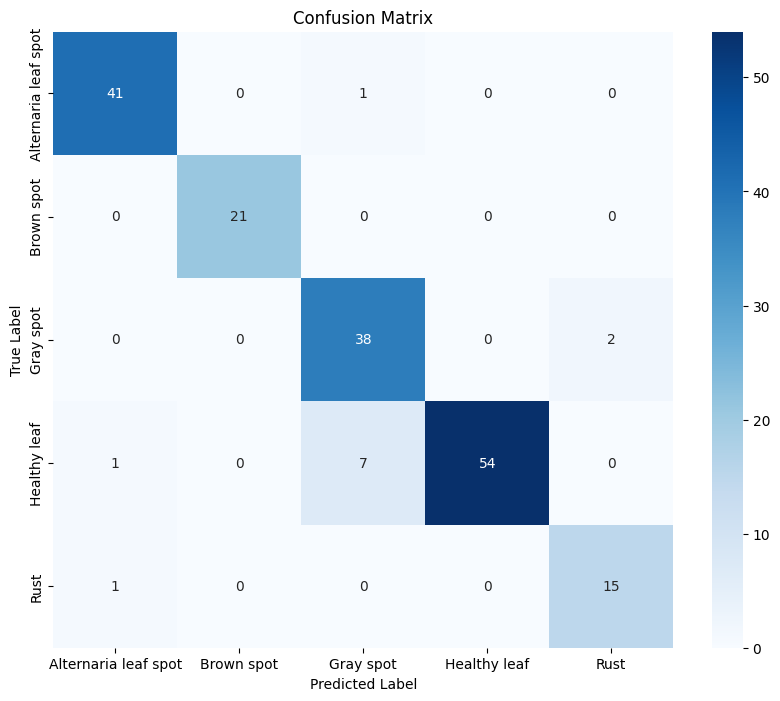

In [24]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(all_labels_np, all_predictions_np)

#class_names = [cls for cls, idx in sorted(train_dataset.class_to_idx.items(), key=lambda item: item[1])]

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

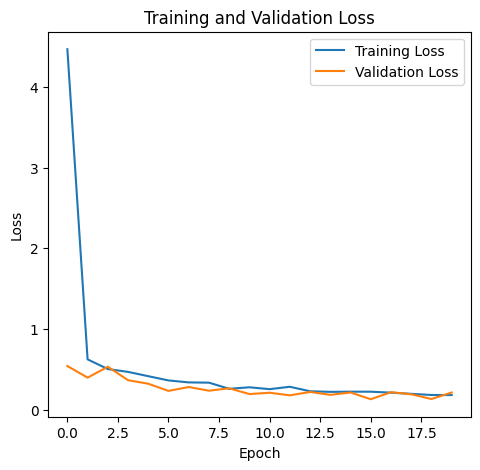

In [25]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

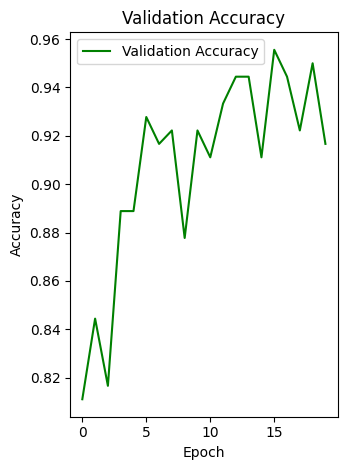

In [26]:
# Plotting the validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

The first plot shows that both the training and validation loss decrease over the epochs, suggesting that the model is learning effectively. The second plot indicates that the validation accuracy generally increases over time, demonstrating the model's improving performance on unseen data during training.

### Transfer Learning

In [28]:
# Load ResNet50 model
resnet50 = models.resnet50(pretrained=True) #use the weights trained on ImageNet

# Remove the classification head
modules = list(resnet50.children())[:-1]
pretrained_model = nn.Sequential(*modules)

print("Pretrained ResNet50 model loaded without the classification head.")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 177MB/s]


Pretrained ResNet50 model loaded without the classification head.


In [29]:
class TransferLearningModel(nn.Module):
    def __init__(self, pretrained_model, num_classes):
        super(TransferLearningModel, self).__init__()
        self.pretrained_base = pretrained_model
        # global average pooling layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # Add a new fully connected layer for classification
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        # Pass the input through the pretrained base
        x = self.pretrained_base(x)
        # Apply global average pooling
        x = self.avgpool(x)
        # Flatten the output
        x = torch.flatten(x, 1)
        # Pass through the new classification layer
        x = self.fc(x)
        return x

In [30]:
# Instantiate the transfer learning model
num_classes = len(train_dataset.classes)
transfer_model = TransferLearningModel(pretrained_model, num_classes=num_classes)

print("Transfer learning model with a new classification head defined.")

Transfer learning model with a new classification head defined.


In [31]:
# Define the loss function
criterion_transfer = nn.CrossEntropyLoss() # Standard Cross-Entropy Loss

# Define the optimizer for training the new classification head
optimizer_transfer = optim.Adam(transfer_model.fc.parameters(), lr=0.001)

In [32]:
# Move the transfer model to the chosen device
transfer_model.to(device)

# Freeze the parameters of the pretrained base
for param in transfer_model.pretrained_base.parameters():
    param.requires_grad = False

print("Pretrained base parameters frozen.")

# Number of epochs for training the classification head
num_epochs_head = 10  # why did I put 10 here. Idiot

print(f"\nTraining the classification head for {num_epochs_head} epochs...")

Pretrained base parameters frozen.

Training the classification head for 10 epochs...


In [33]:
# Lists to store training and validation loss and accuracy for head training
train_losses_head = []
val_losses_head = []
val_accuracies_head = []

# Training Loop for the Classification Head
for epoch in range(num_epochs_head):
    # --- Training Phase ---
    transfer_model.train() # Set the model to training mode
    running_loss_head = 0.0
    for images, labels in train_loader:
        # Move data to the chosen device
        images = images.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer_transfer.zero_grad()

        # Forward pass
        outputs = transfer_model(images)
        loss = criterion_transfer(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer_transfer.step()

        running_loss_head += loss.item() * images.size(0)

    epoch_train_loss_head = running_loss_head / len(train_loader.dataset)
    train_losses_head.append(epoch_train_loss_head)

    # --- Validation Phase ---
    transfer_model.eval() # Set the model to evaluation mode
    running_val_loss_head = 0.0
    correct_predictions_head = 0
    total_samples_head = 0

    with torch.no_grad(): # Disable gradient calculation during validation
        for images, labels in val_loader:
            # Move data to the chosen device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = transfer_model(images)
            loss = criterion_transfer(outputs, labels)

            running_val_loss_head += loss.item() * images.size(0)

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_samples_head += labels.size(0)
            correct_predictions_head += (predicted == labels).sum().item()

    epoch_val_loss_head = running_val_loss_head / len(val_loader.dataset)
    epoch_val_accuracy_head = correct_predictions_head / total_samples_head

    val_losses_head.append(epoch_val_loss_head)
    val_accuracies_head.append(epoch_val_accuracy_head)

    # Print epoch results
    print(f"Epoch [{epoch+1}/{num_epochs_head}], "
          f"Train Loss: {epoch_train_loss_head:.4f}, "
          f"Val Loss: {epoch_val_loss_head:.4f}, "
          f"Val Accuracy: {epoch_val_accuracy_head:.4f}")

print("\nTraining of classification head finished.")

Epoch [1/10], Train Loss: 0.9129, Val Loss: 0.4231, Val Accuracy: 0.9222
Epoch [2/10], Train Loss: 0.4761, Val Loss: 0.2989, Val Accuracy: 0.9278
Epoch [3/10], Train Loss: 0.3375, Val Loss: 0.2277, Val Accuracy: 0.9556
Epoch [4/10], Train Loss: 0.2952, Val Loss: 0.2199, Val Accuracy: 0.9611
Epoch [5/10], Train Loss: 0.2426, Val Loss: 0.1885, Val Accuracy: 0.9556
Epoch [6/10], Train Loss: 0.2475, Val Loss: 0.1880, Val Accuracy: 0.9389
Epoch [7/10], Train Loss: 0.2157, Val Loss: 0.1949, Val Accuracy: 0.9444
Epoch [8/10], Train Loss: 0.2267, Val Loss: 0.1859, Val Accuracy: 0.9444
Epoch [9/10], Train Loss: 0.2073, Val Loss: 0.1695, Val Accuracy: 0.9389
Epoch [10/10], Train Loss: 0.1769, Val Loss: 0.1513, Val Accuracy: 0.9611

Training of classification head finished.


#### Evaluate on test set

In [34]:
transfer_model.eval()
running_test_loss_transfer = 0.0
correct_predictions_test_transfer = 0
total_samples_test_transfer = 0

all_labels_transfer = []
all_predictions_transfer = []

print("Evaluating transfer learning model on the test set...")

with torch.no_grad(): # Disable gradient calculation during testing
    for images, labels in tqdm(test_loader, desc="Evaluating Transfer Model"):
        # Move data to the chosen device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = transfer_model(images)
        loss = criterion_transfer(outputs, labels)

        running_test_loss_transfer += loss.item() * images.size(0) # Accumulate test loss

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_samples_test_transfer += labels.size(0)
        correct_predictions_test_transfer += (predicted == labels).sum().item()

        # Store labels and predictions for other metrics
        all_labels_transfer.extend(labels.cpu().numpy())
        all_predictions_transfer.extend(predicted.cpu().numpy())

Evaluating transfer learning model on the test set...


Evaluating Transfer Model: 100%|██████████| 6/6 [00:01<00:00,  5.51it/s]


In [35]:
test_loss_transfer = running_test_loss_transfer / len(test_loader.dataset)
test_accuracy_transfer = correct_predictions_test_transfer / total_samples_test_transfer

print(f"\nTransfer Learning Model Test Loss: {test_loss_transfer:.4f}")
print(f"Transfer Learning Model Test Accuracy: {test_accuracy_transfer:.4f}")


Transfer Learning Model Test Loss: 0.1136
Transfer Learning Model Test Accuracy: 0.9724


In [36]:
# Convert stored labels and predictions to numpy arrays
all_labels_transfer_np = np.array(all_labels_transfer)
all_predictions_transfer_np = np.array(all_predictions_transfer)

# Calculate overall accuracy
overall_accuracy_transfer = accuracy_score(all_labels_transfer_np, all_predictions_transfer_np)
print(f"Overall Transfer Learning Model Test Accuracy: {overall_accuracy_transfer:.4f}")

# Calculate precision, recall, and F1-score for each class
precision_transfer, recall_transfer, f1_score_transfer, _ = precision_recall_fscore_support(
    all_labels_transfer_np,
    all_predictions_transfer_np,
    average=None,
    labels=np.arange(len(train_dataset.classes)) # Ensure order matches class_to_idx
)

# Get class names in the correct order
class_names = [cls for cls, idx in sorted(train_dataset.class_to_idx.items(), key=lambda item: item[1])]

print("\nPer-Class Evaluation Metrics (Transfer Learning Model):")
for i, class_name in enumerate(class_names):
    print(f"  {class_name}:")
    print(f"    Precision: {precision_transfer[i]:.4f}")
    print(f"    Recall: {recall_transfer[i]:.4f}")
    print(f"    F1-score: {f1_score_transfer[i]:.4f}")

Overall Transfer Learning Model Test Accuracy: 0.9724

Per-Class Evaluation Metrics (Transfer Learning Model):
  Alternaria leaf spot:
    Precision: 1.0000
    Recall: 0.9286
    F1-score: 0.9630
  Brown spot:
    Precision: 1.0000
    Recall: 1.0000
    F1-score: 1.0000
  Gray spot:
    Precision: 0.9091
    Recall: 1.0000
    F1-score: 0.9524
  Healthy leaf:
    Precision: 0.9841
    Recall: 1.0000
    F1-score: 0.9920
  Rust:
    Precision: 1.0000
    Recall: 0.8750
    F1-score: 0.9333


The transfer learning model achieved a high overall test accuracy of 0.9724. Excellent per-class performance was observed, with perfect scores for 'Brown spot' and high F1-scores across all classes, ranging from 0.9333 ('Rust') to 1.0000 ('Brown spot'), indicating robust classification capabilities.

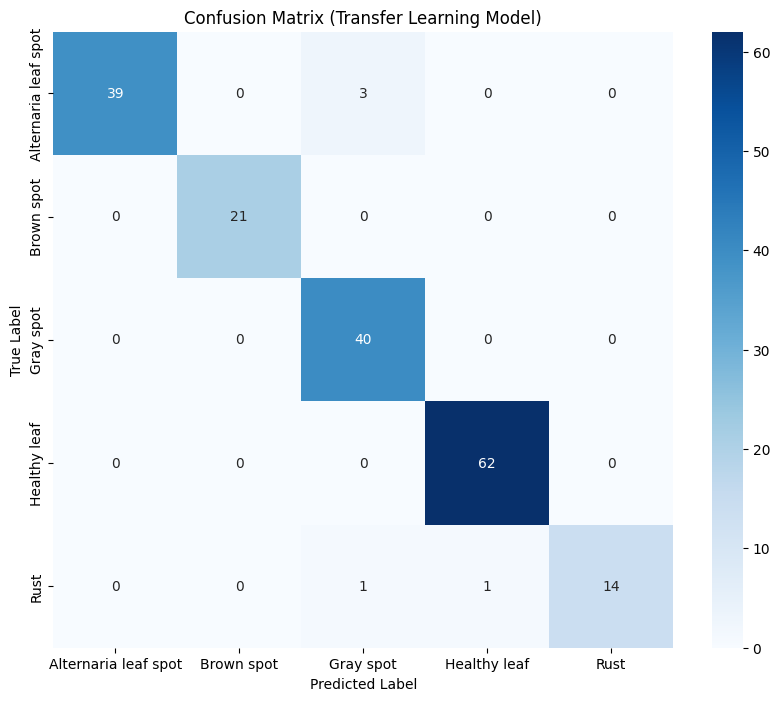

In [37]:
# Confusion matrix
conf_matrix_transfer = confusion_matrix(all_labels_transfer_np, all_predictions_transfer_np)

# Get class names in the correct order
class_names = [cls for cls, idx in sorted(train_dataset.class_to_idx.items(), key=lambda item: item[1])]

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_transfer, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Transfer Learning Model)')
plt.show()

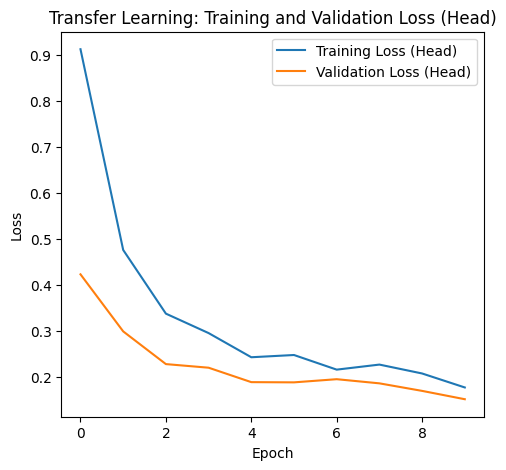

In [38]:
# Plotting the training and validation loss for Transfer Learning Model
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses_head, label='Training Loss (Head)')
plt.plot(val_losses_head, label='Validation Loss (Head)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Transfer Learning: Training and Validation Loss (Head)')
plt.legend()

This plot shows a clear decrease in both the training and validation loss over the epochs. This indicates that the model's classification head is effectively learning to classify the images based on the features extracted by the frozen pretrained base. The convergence of both curves suggests that the training of the head is stable and not overfitting significantly at this stage.

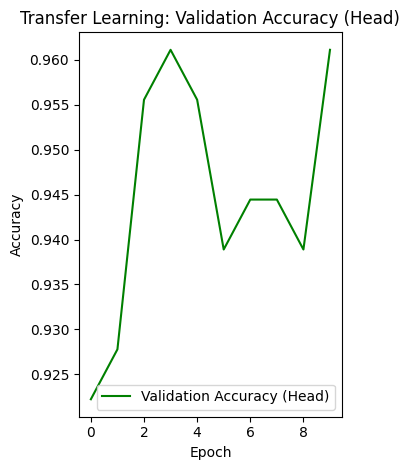

In [39]:
# Plotting the validation accuracy for Transfer Learning Model
plt.subplot(1, 2, 2)
plt.plot(val_accuracies_head, label='Validation Accuracy (Head)', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Transfer Learning: Validation Accuracy (Head)')
plt.legend()

plt.tight_layout()
plt.show()

This plot demonstrates an upward trend in validation accuracy over the training epochs. The accuracy quickly increases and then stabilizes at a high level (around 0.94 to 0.96). This signifies that the transfer learning approach, even with just training the classification head, is achieving good performance on unseen validation data, leveraging the powerful features learned by the pretrained ResNet50 model.

## Model Comparison

Summary of the key evaluation metrics for both the Simple CNN and the Transfer Learning models:

### Simple CNN Model Performance

*   **Overall Test Accuracy:** 0.9337
*   **Per-Class Evaluation Metrics:**
    *   Alternaria leaf spot: Precision: 0.9535, Recall: 0.9762, F1-score: 0.9647
    *   Brown spot: Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
    *   Gray spot: Precision: 0.8261, Recall: 0.9500, F1-score: 0.8837
    *   Healthy leaf: Precision: 1.0000, Recall: 0.8710, F1-score: 0.9310
    *   Rust: Precision: 0.8824, Recall: 0.9375, F1-score: 0.9091

### Transfer Learning Model Performance

*   **Overall Test Accuracy:** 0.9724
*   **Per-Class Evaluation Metrics:**
    *   Alternaria leaf spot: Precision: 1.0000, Recall: 0.9286, F1-score: 0.9630
    *   Brown spot: Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
    *   Gray spot: Precision: 0.9091, Recall: 1.0000, F1-score: 0.9524
    *   Healthy leaf: Precision: 0.9841, Recall: 1.0000, F1-score: 0.9920
    *   Rust: Precision: 1.0000, Recall: 0.8750, F1-score: 0.9333


Comparing the overall test accuracies, the Transfer Learning model achieved a higher accuracy of 0.9724 compared to the Simple CNN model's accuracy of 0.9337. This indicates that the transfer learning approach resulted in better overall performance on the unseen test data.

## Model interpretability

## Additional Enhancements

- Fine-Tuning & Optimization
- Test model generalization on external apple leaf datasets.
- Apply Grad-CAM or saliency maps for model interpretability.
- Package as a web/mobile demo using frameworks like Streamli.